# <center/>使用PyNative进行神经网络的训练调试体验

## 概述

在神经网络训练过程中，数据是否按照自己设计的神经网络运行，是使用者非常关心的事情，如何去查看数据是怎样经过神经网络，并产生变化的呢？这时候需要AI框架提供一个功能，方便使用者将计算图中的每一步变化拆开成单个算子或者深层网络拆分成多个单层来调试观察，了解分析数据在经过算子或者计算层后的变化情况，MindSpore在设计之初就提供了这样的功能模式--`PyNative_MODE`，与此对应的是`GRAPH_MODE`，他们的特点分别如下：
- PyNative模式：也称动态图模式，将神经网络中的各个算子逐一下发执行，方便用户编写和调试神经网络模型。
- Graph模式：也称静态图模式或者图模式，将神经网络模型编译成一整张图，然后下发执行。该模式利用图优化等技术提高运行性能，同时有助于规模部署和跨平台运行。

默认情况下，MindSpore处于PyNative模式，可以通过`context.set_context(mode=context.GRAPH_MODE)`切换为Graph模式；同样地，MindSpore处于Graph模式时，可以通过`context.set_context(mode=context.PYNATIVE_MODE)`切换为PyNative模式。

<br/>本次体验我们将使用一张手写数字图片跑完单次训练，在PyNative模式下，将数据在训练中经过每层神经网络的变化情况打印出来，并计算对应的loss值以及梯度值`grads`，整体流程如下：

1. 数据集准备，并取用单张图片数据。

2. 构建神经网络并设置每层断点打印数据。

3. 构建梯度计算函数。

4. 执行神经网络训练，查看网络各参数梯度。

> 你可以在这里找到完整可运行的样例代码：<https://gitee.com/mindspore/docs/blob/r1.0/tutorials/tutorial_code/lenet/lenet.py>。

## 数据准备

### 数据集的下载

这里我们需要将MNIST数据集中随机取出一张图片，并增强成适合LeNet网络的数据格式（如何处理请参考[quick_start.ipynb](https://gitee.com/mindspore/docs/blob/r1.0/tutorials/notebook/quick_start.ipynb)），训练数据集下载地址：{"<http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz>", "<http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz>"} 。
<br/>数据集放在----Jupyter工作目录+\MNIST_Data\train\，如下图结构：

### 数据集的增强操作

下载下来后的数据集，需要通过`mindspore.dataset`处理成适用于MindSpore框架的数据，再使用一系列框架中提供的工具进行数据增强操作来适应LeNet网络的数据处理需求。

In [1]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype
import mindspore.dataset as ds
import numpy as np

def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) 
    rescale_op = CV.Rescale(rescale, shift) 
    hwc2chw_op = CV.HWC2CHW()  
    type_cast_op = C.TypeCast(mstype.int32)

    # using map method to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
   
    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

### 数据图片的提取

本次体验我们只需要一张图片进行训练体验，所以随机选取`batch`中的第一张图片`image`和下标`label`。

(32, 1, 32, 32)


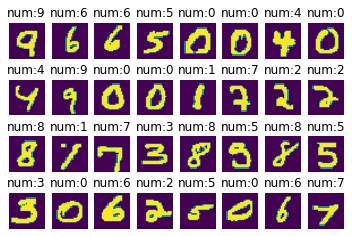

In [2]:
from mindspore import Tensor
import matplotlib.pyplot as plt
train_data_path = "./MNIST_Data/train/" 
datas = create_dataset(train_data_path)
data1 = datas.create_dict_iterator()
data= data1.get_next()
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
print(images.shape)
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

当前batch的image数据如上图，后面的体验将提取第一张图片进行训练操作。

### 定义图像显示函数

定义一个图像显示函数`image_show`，插入LeNet5的前面4层神经网络中抽取图像数据并显示。

In [3]:
def image_show(x):
    count = 1
    x = x.asnumpy()
    number = x.shape[1]
    sqrt_number = int(np.sqrt(number))
    for i in x[0]:
        plt.subplot(sqrt_number,int(number/sqrt_number),count)
        plt.imshow(i)
        count += 1
    plt.show()

## 构建神经网络LeNet5
在`construct`中使用`image_show`，查看每层网络后的图片变化。
> 这里只抽取了图片显示，想要查看具体的数值，可以按照自己的需要进行`print(x)`。

In [4]:
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common import dtype as mstype
from mindspore.common.initializer import TruncatedNormal
from mindspore.nn import Dense

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """weight initial for conv layer"""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")

def fc_with_initialize(input_channels, out_channels):
    """weight initial for fc layer"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)
    
def weight_variable():
    """weight initial"""
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    def __init__(self, num_class=10):
        super(LeNet5, self).__init__()
        self.num_class = num_class
        self.batch_size = 1
        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.reshape = ops.Reshape()
        self.switch = 1
        
    def construct(self, x):
        
        x = self.conv1(x)
        if self.switch > 0:
            print("The first layer: convolution layer")
            image_show(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        if self.switch > 0:
            print("The second layer: pool layer")
            image_show(x)
        x = self.conv2(x)
        if self.switch > 0:
            print("The third layer: convolution layer")
            image_show(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        if self.switch > 0:
            print("The fourth layer: pool layer")
            image_show(x)
        x = self.reshape(x, (self.batch_size, -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        self.switch -= 1
        return x

In [5]:
print(LeNet5())

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=Parameter (name=conv1.weight), bias_init=None>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=Parameter (name=conv2.weight), bias_init=None>
  (fc1): Dense<in_channels=400, out_channels=120, weight=Parameter (name=fc1.weight), has_bias=True, bias=Parameter (name=fc1.bias)>
  (fc2): Dense<in_channels=120, out_channels=84, weight=Parameter (name=fc2.weight), has_bias=True, bias=Parameter (name=fc2.bias)>
  (fc3): Dense<in_channels=84, out_channels=10, weight=Parameter (name=fc3.weight), has_bias=True, bias=Parameter (name=fc3.bias)>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  >


## 构建计算梯度函数GradWrap
构建梯度下降求值函数，该函数可计算网络中所有权重的梯度。

In [6]:
from mindspore import context, Tensor, ParameterTuple
context.set_context(mode=context.PYNATIVE_MODE, device_target = "GPU")

class GradWrap(nn.Cell):
    """ GradWrap definition """
    def __init__(self, network):
        super(GradWrap, self).__init__(auto_prefix=False)
        self.network = network
        self.weights = ParameterTuple(filter(lambda x: x.requires_grad, network.get_parameters()))

    def construct(self, x, label):
        weights = self.weights
        return ops.GradOperation(get_by_list=True)(self.network, weights)(x, label)

## 执行训练函数

执行前需要使用`context.set_context`将模式设置成`PYNATIVE_MODE`。然后可以从网络中查看当前`batch`中第一张图片`image`的数据在神经网络中的变化，经过神经网络后，计算出其loss值，再根据loss值求参数的偏导即神经网络的梯度值，最后将梯度和loss进行优化。
- image：为当前batch的第一张图片。
- output：表示图片数据经过当前网络训练后生成的值，其张量为（1,10）。

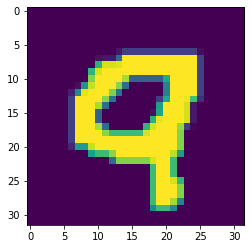

The first layer: convolution layer


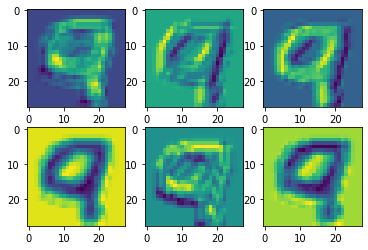

The second layer: pool layer


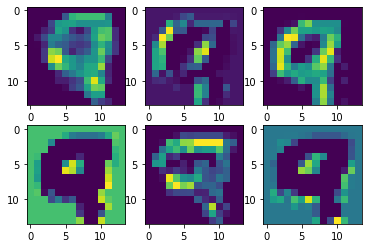

The third layer: convolution layer


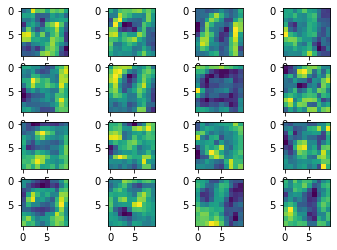

The fourth layer: pool layer


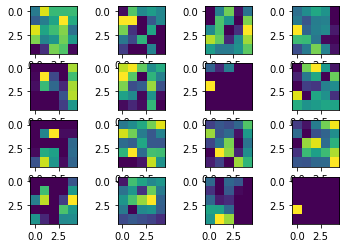

In [7]:
from mindspore.nn import WithLossCell, SoftmaxCrossEntropyWithLogits, Momentum

net = LeNet5()
optimizer = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.1, 0.9)
criterion = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_with_criterion = WithLossCell(net, criterion)
train_network = GradWrap(net_with_criterion)
train_network.set_train()

image = images[0][0]
image = image.reshape((1,1,32,32))
plt.imshow(np.squeeze(image))
plt.show()
input_data = Tensor(np.array(image).astype(np.float32))
label = Tensor(np.array([labels[0]]).astype(np.int32))
output = net(Tensor(input_data))

将第一层卷积层、第二层池化层、第三层卷积层和第四层池化层的图像特征打印出来后，直观地看到随着深度的增加，图像特征几乎无法用肉眼识别，但是机器可以用这些特征进行学习和识别，后续的全连接层为二维数组，无法图像显示，但可以打印出数据查看，由于数据量过大此处就不打印了，用户可以根据需求选择打印。

### 求loss值和梯度值，并进行优化

先求得loss值，后再根据loss值求梯度（偏导函数值），使用优化器`optimizer`进行优化。
- `loss_output`：即为loss值。
- `grads`：即网络中每层权重的梯度。
- `net_params`：即网络中每层权重的名称，用户可执行`print(net_params)`自行打印。
- `success`：优化参数。

In [8]:
loss_output = criterion(output, label)
grads = train_network(input_data, label)
net_params = net.trainable_params()
for i in range(len(grads)):
    print("{}:".format(net_params[i].name),grads[i].shape)
success = optimizer(grads)
loss = loss_output.asnumpy()
print("Loss_value:",loss)

already has forward run before grad by user
conv1.weight: (6, 1, 5, 5)
conv2.weight: (16, 6, 5, 5)
fc1.weight: (120, 400)
fc1.bias: (120,)
fc2.weight: (84, 120)
fc2.bias: (84,)
fc3.weight: (10, 84)
fc3.bias: (10,)
Loss_value: 2.2908278


具体每层权重的参数有多少，从打印出来的梯度张量能够看到，对应的梯度值用户可以自行选择打印。

## 总结

本次体验我们将MindSpore的数据增强后，使用了`create_dict_iterator`转化成字典，再单独取出来；使用PyNative模式将神经网络分层单独调试，提取并观察数据；用`WithLossCell`在PyNative模式下计算loss值；构造梯度函数`GradWrap`将神经网络中各个权重的梯度计算出来，以上就是本次的全部体验内容。